In [1]:
# change the seed before anything else
import numpy as np
np.random.seed(7)
import tensorflow as tf
tf.set_random_seed(7)
from timeit import default_timer as timer

import os
import time

import keras
keras.backend.clear_session()

import matplotlib.pyplot as plt
import sklearn

from keras.models import Sequential, Input, Model
from keras.layers import Activation
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l2
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

from keras.layers.normalization import BatchNormalization

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)
Using TensorFlow backend.


In [2]:
frames = 101
bands = 60
feature_size = bands * frames
num_channels = 3
num_labels = 10
data_dir = 'folds_2channel'

In [3]:
def load_all_folds(test_fold):
    assert (type(test_fold) == int)
    assert (test_fold > 0 and test_fold < 11)
    subsequent_fold = False

    train_set_range = list(range(1, 11))
    train_set_range.remove(test_fold)
    valid_fold = train_set_range.pop()

    for k in train_set_range:
        fold_name = 'fold' + str(k)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        # flip the spectrogram for each channel
        loaded_features = np.transpose(loaded_features, (0, 2, 1, 3))
        loaded_labels = np.load(labels_file)
        print("Adding ", fold_name, "New Features: ", loaded_features.shape)

        if subsequent_fold:
            train_x_loaded = np.concatenate((train_x_loaded, loaded_features))
            train_y_loaded = np.concatenate((train_y_loaded, loaded_labels))
        else:
            train_x_loaded = loaded_features
            train_y_loaded = loaded_labels
            subsequent_fold = True

    # use the penultimate fold for validation
    valid_fold_name = 'fold' + str(valid_fold)
    feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
    valid_x = np.load(feature_file)
    # flip the spectrogram for each channel
    valid_x = np.transpose(valid_x, (0, 2, 1, 3))
    valid_y = np.load(labels_file)

    # and use the last fold for testing
    test_fold_name = 'fold' + str(test_fold)
    feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
    test_x = np.load(feature_file)
    test_x = np.transpose(test_x, (0, 2, 1, 3))
    test_y = np.load(labels_file)
    return train_x_loaded, train_y_loaded, valid_x, valid_y, test_x, test_y

In [4]:
def evaluate(model, test_x, test_y):
    y_prob = model.predict(test_x, verbose=0)
    y_pred = np.argmax(y_prob, axis=-1)
    y_true = np.argmax(test_y, 1)

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
    print("\nAccuracy = {:.4f}".format(accuracy))
    print("\nError Rate = {:.4f}".format(1. - accuracy))

    return accuracy

In [5]:
def build_model():

    # create model 
    visible = Input(shape=(frames, bands, num_channels))
    
    # 2 conv + 2 pool layers
    conv1 = Conv2D(80, kernel_size=(57, 6), strides=(1, 1), activation='relu', kernel_regularizer=l2(0.001))(visible)
    dropout1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling2D(pool_size=(4, 3), strides=(1, 3))(conv1) 
    conv2 =Conv2D(80, kernel_size=(1, 3), strides=(1, 1), activation='relu', kernel_regularizer=l2(0.001))(pool1)
    pool2 = MaxPooling2D(pool_size=(1, 3), strides=(1, 3))(conv2)
    # flatten from 4 to only 2 dimensions
    flatten = Flatten()(pool2)
    # 2 fully connected Layers
    fc1 = Dense(5000, activation = "relu", kernel_regularizer=l2(0.001))(flatten)
    fc1 = Dropout(0.5)(fc1)
    fc2 = Dense(5000, activation = "relu", kernel_regularizer=l2(0.001))(fc1)
    fc2 = Dropout(0.5)(fc2)
    # softmax output layer
    softmax = Dense(10, activation = "softmax", kernel_regularizer=l2(0.001))(fc2)
    model = Model(inputs=visible, outputs=softmax)
    # print(model.summary())
    
    return model

In [6]:
# apply scaling factor to a dataset - train, validation or test
def do_scale(x4d, verbose = True):
    """Do scale on the input sequence data.

    Args:
      x34d: ndarray, input sequence data, shape: (n_clips, n_time, n_freq, channel)      
      verbose: boolean

    Returns:
      Scaled input sequence data.
    """
    t1 = time.time()    
    (n_clips, n_time, n_freq, n_channel) = x4d.shape
    x4d_scaled = np.zeros(x4d.shape)
    for channel in range(n_channel):
        x2d = x4d[:,:,:,channel].reshape((n_clips * n_time, n_freq))
        x2d_scaled = scaler_list[channel].transform(x2d)
        x3d_scaled = x2d_scaled.reshape((n_clips, n_time, n_freq))
        x4d_scaled[:,:,:,channel] = x3d_scaled

    if verbose == 1:
        print("Scaling time: %s" % (time.time() - t1,))

    return x4d_scaled

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks = [early_stopping]

acc_list = []

for test_fold in range(1, 11):
    print('opening fold:', str(test_fold))
    keras.backend.clear_session()
    model = build_model()

    # compile the model
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001, momentum=0.9, nesterov=True), metrics=['accuracy'])
    train_x, train_y, valid_x, valid_y, test_x, test_y = load_all_folds(test_fold)

    # for each channel, compute scaling factor
    scaler_list = []
    (n_clips, n_time, n_freq, n_channel) = train_x.shape

    for channel in range(n_channel):
        t1 = time.time()
        xtrain_2d = train_x[:, :, :, channel].reshape((n_clips * n_time, n_freq))
        scaler = sklearn.preprocessing.StandardScaler().fit(xtrain_2d)
        # print("Channel %d Mean: %s" % (channel, scaler.mean_,))
        # print("Channel %d Std: %s" % (channel, scaler.scale_,))
        # print("Calculating scaler time: %s" % (time.time() - t1,))
        scaler_list += [scaler]

    train_x = do_scale(train_x)
    valid_x = do_scale(valid_x)
    test_x = do_scale(test_x)

    # use a batch size to fully utilize GPU power
    t1 = time.time()
    print("training model...hold tight")
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=callbacks,
                        batch_size=1000,
                        epochs=150)
    print("training time: %s" % (time.time() - t1,))
    
    t2 = time.time()
    acc = evaluate(model, test_x, test_y)
    print("training time: %s" % (time.time() - t2,))

    acc_list += [acc]

opening fold: 1
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Adding  fold2 New Features:  (887, 101, 60, 3)
Adding  fold3 New Features:  (925, 101, 60, 3)
Adding  fold4 New Features:  (990, 101, 60, 3)
Adding  fold5 New Features:  (936, 101, 60, 3)
Adding  fold6 New Features:  (823, 101, 60, 3)
Adding  fold7 New Features:  (838, 101, 60, 3)
Adding  fold8 New Features:  (806, 101, 60, 3)
Adding  fold9 New Features:  (816, 101, 60, 3)
Scaling time: 1.829319953918457
Scaling time: 0.2275373935699463
Scaling time: 0.23914408683776855
training model...hold tight
Train on 7021 samples, validate on 837 samples
Epoch 1/150
7021/7021 [==============================] - 14s - loss: 15.1202 - acc: 0.1147 - val_loss: 15.0748 - val_acc: 0.1792
Epoch 2/150
7021/7021 [==============================] - 2s - loss: 15.0762 - acc: 0.1

In [8]:
acc_array = np.array(acc_list)
print("acc mean %.4f acc std %.4f" % (acc_array.mean(), acc_array.std()))

acc mean 0.5638 acc std 0.0911


History keys: dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


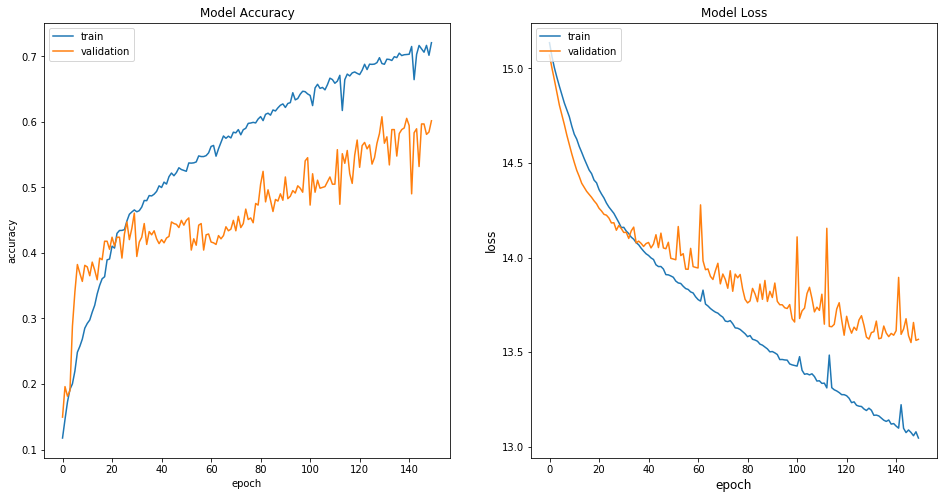

In [9]:
fig = plt.figure(figsize=(16,8))

print("History keys:", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss', fontsize = 'large')
plt.xlabel('epoch', fontsize = 'large' )
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


800/837 [===========================>..] - ETA: 0s
Accuracy = 0.5830

Error Rate = 0.4170
Showing Confusion Matrix
                    air conditioner            horn        children             dog           drill          engine             gun          hammer           siren           music 
    air conditioner              67               0               0               0               0               0               0              33               0               0 
               horn               1              11               5               7               1               0               1               4               1               2 
           children               2               5              63              11               2               2               0               0               8               7 
                dog               2               7              12              67               3               0               0               0              

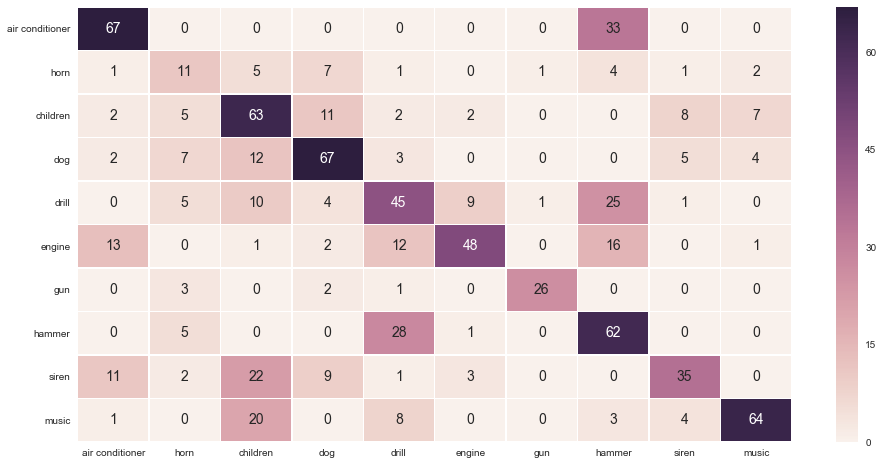

In [10]:
% matplotlib inline
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

# run a separate instance of model evaluation on test set
# to create a single confusion matrix

acc = evaluate(model, test_x, test_y) 

labels = ["air conditioner", "horn", "children", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
print("Showing Confusion Matrix")
y_prob = model.predict(test_x, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=' ')
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=' ')
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=' ')
        print()

print_cm(cm, labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(16, 8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)